In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = False

roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9]
get_crit_T = dict(zip(jds, roots))
num_temps = 100

def errs(errs):
    return np.array([sum(errs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_err(errs):
    return np.array([np.std(errs[i*512:(i+1)*512]) for i in range(num_temps)])

markers=['.', '^', 'X', 's', '*', 'p']
colors=['blue', 'orange', 'green', 'red', 'm', 'gold']

In [2]:
Jd = 0.0
J = 1.0
T_c = get_crit_T[Jd]
T = np.round(np.linspace(T_c - 0.3, T_c + 0.3, num_temps), 4)

Ls = [20, 30, 60, 80, 120]

spins_ = {L : [] for L in Ls}
for i, L in enumerate(Ls):
    if Jd == 0.0:
        PATH = f'data_spins/{Jd}_train/spins_{L}_{T[0]}_{T[-1]}.npz'
        spins_[L].append(np.load(PATH))
    # with open(f'data_spins/{Jd}_test/spins_{L}_{T[0]}_{T[-1]}.npz', 'rb') as f:
    #     spins_[L].append(np.load(f)) 
    PATH = f'data_spins/{Jd}_test/spins_{L}_{T[0]}_{T[-1]}.npz'
    spins_[L].append(np.load(PATH))

In [16]:
spins_[20][0][f'T_0'][0].shape

(20, 20)

In [15]:
a = np.zeros((10, 5, 5))
a = a.reshape(a.shape[0], -1)
a.shape

(10, 25)

### $\chi(T)$

In [26]:
def suscept_per_t(spins, L, t):
    """
    spins (num_conf, L, L): tensor of Ising lattices at temperature t
    """
    m2 = 0.
    m_2 = 0.
    num_conf = spins.shape[0]
    for i in range(num_conf):
        m2 += ((np.sum(spins[i])) / L**2)**2
        m_2 += np.abs((np.sum(spins[i])) / L**2)
    m2 = m2 / num_conf
    m_2 = (m_2 / num_conf)**2
    return L**2 / t * (m2 - m_2)

In [27]:
suscept = {L : [] for L in Ls}
for L in Ls:
    for j in range(num_temps):
        suscept[L].append(suscept_per_t(spins_[L][0][f'T_{j}'], L, T[j]))

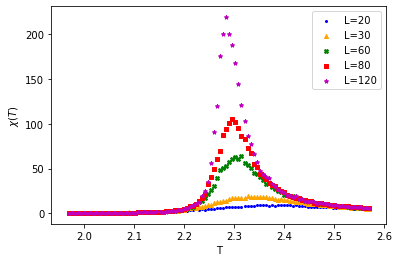

In [28]:
plt.scatter(T, suscept[20], c=colors[0], label='L=20', marker=markers[0], s=16)
plt.scatter(T, suscept[30], c=colors[1], label='L=30', marker=markers[1], s=16)
plt.scatter(T, suscept[60], c=colors[2], label='L=60', marker=markers[2], s=16)
plt.scatter(T, suscept[80], c=colors[3], label='L=80', marker=markers[3], s=16)
plt.scatter(T, suscept[120], c=colors[4], label='L=120', marker=markers[4], s=16)
plt.legend()
plt.xlabel('T')
plt.ylabel('$\chi(T)$')
plt.show()

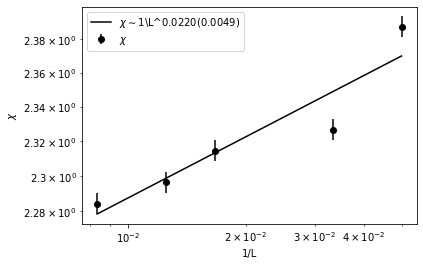

In [29]:
from scipy.optimize import curve_fit

chi_maxs = [T[np.argmax(suscept[L])] for L in Ls]

def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80, 120]])

pl_, pcov_ = line_fit(y=np.log(np.abs(chi_maxs)), x=np.log(ls))

perr_line = np.sqrt(np.diag(pcov_))

plt.errorbar(ls, chi_maxs, yerr=6e-3, fmt="o", color='black', label='$\chi$')

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black', label='$\chi\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))

#plt.title(f'M = {M}')
plt.xlabel('1/L')
plt.ylabel('$\chi$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig(f'images/{M}-mu.png')

In [3]:
%load_ext cython

In [28]:
%%cython -a --cplus --compile-args=-std=c++11 -I</home/ddsukhoverkhova/.conda/envs/mc_lib_env/lib/python3.7/site-packages/mc_lib>
import numpy as np
cimport numpy as cnp

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable

import time
import os


cdef RndmWrapper rndm = RndmWrapper((1234, 0)) # global variable
    
cdef void init_spins(cnp.int32_t[::1] spins): 
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
# @cython.boundscheck(False)
# @cython.wraparound(False)
cdef double energy(double[::1] spins, 
                   double[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0


# @cython.boundscheck(False)
# @cython.wraparound(False)
cdef void flip_spin(cnp.int32_t[::1] spins, 
                    cnp.int32_t[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js,
                    const double[::1] ratios,
                    int nDim1,
                    int nDim2): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef int num_neighb = neighbors[site, 0]
    cdef long summ1 = 0 # J
    cdef long summ2 = 0 # Jd
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        if Js[site,site1] == 1.0: # FIXME: wider range of J
            summ1 += spins[site1] #* spins[site] * Js[site,site1]
        else:
            summ2 += spins[site1]
    
    cdef double ratio = ratios[nDim1 + summ1 * spins[site] + nDim2 + summ2 * spins[site] + nDim1 * ((summ1 * spins[site] + nDim1) // 2)] #+ ratios2[nDim2 + summ2 * spins[site]]) #exp(-2.0 * beta * summ )
    
    if ratio < 1:
        if rndm.uniform() > ratio:
            return

    spins[site] *= -1
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2 , int L3 = 1):
  
    if L3 == 1:
        for i in range(L1*L2):
            Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
            Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
            Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
            Js[i, (i + L2) % (L1*L2)] = J
            Js[i, (i // L2) * L2 + (i - 1) % L2] = J
            Js[i, (i - L2) % (L1*L2)] = J
        return
    
    else:
        return

    
@cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.cdivision(False)
cdef double _get_energy_magn_jd(Py_ssize_t L,
             double J, double Jd,
             double[::1] spins):

    
    cdef:
        double[:, ::1] neighbors = np.asarray(tabulate_neighbors(L, kind='triang'), double)
        #cnp.int32_t[:, ::1] neighbors = np.asarray(tabulate_neighbors((L, L, 1), kind='sc'), np.int32)
        
    cdef:
        int i
        double av_en = 0., Z = 0., magn = 0., av_magn=0., en = 0.

    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    
    for i in range(L*L):
        magn += spins[i]
        
    magn = magn / L**2
        
    magn_2 = magn**2 / L**2
        
    en = energy(spins, neighbors, Js) / L**2

#     m2.add_measurement(magn**2)
#     m4.add_measurement(magn**4)
#     m[sweep] = magn
        
    return (en, magn, magn_2)  

def get_energy_magn_jd(L, J, Jd, spins):
    return _get_energy_magn_jd(L, J, Jd, spins)


Error compiling Cython file:
------------------------------------------------------------
...
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
^
------------------------------------------------------------

/home/ddsukhoverkhova/.cache/ipython/cython/_cython_magic_02010250f62ceed9b27866e5552346fe.pyx:21:0: Cdef functions/classes cannot take arbitrary decorators.


In [26]:
%%time
suscept = {L : [] for L in Ls}
for L in Ls:
    for j in range(num_temps):
        for snap in range(spins_[L][0][f'T_{j}'].shape[0]):
            suscept[L].append(get_energy_magn_jd(L, J, Jd, spins_[L][0][f'T_{j}'][snap].reshape(-1)))

ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'double'

### $C(T)$

In [4]:
def H(lattice, L, J, Jd):
    """
    lattice (L, L): Ising lattice
    """
    en = 0.
    for i in range(L):
        for j in range(L):
            en -= lattice[i, j] * lattice[i, (j + 1) // L] * J + lattice[i, j] * lattice[(i + 1) // L, (j + 1) // L] * Jd
    return en

def cap_per_t(spins, L, t, J, Jd):
    """
    spins (num_conf, L, L): tensor of Ising lattices at temperature t
    """
    e2 = 0.
    e_2 = 0.
    num_conf = spins.shape[0]
    for i in range(num_conf):
        e2 += (H(spins[i], L, J, Jd) / L**2)**2
        e_2 += H(spins[i], L, J, Jd) / L**2
    e2 = e2 / num_conf
    e_2 = (e_2 / num_conf)**2
    return L**2 / t**2 * (e2 - e_2)

In [6]:
capacity = {L : [] for L in Ls}
for L in tqdm(Ls):
    for j in tqdm(range(num_temps)):
        capacity[L].append(cap_per_t(spins_[L][0][f'T_{j}'], L, T[j], J, Jd))

  0%|          | 0/5 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.scatter(T, capacity[20], c=colors[0], label='L=20', marker=markers[0], s=16)
plt.scatter(T, capacity[30], c=colors[1], label='L=30', marker=markers[1], s=16)
plt.scatter(T, capacity[60], c=colors[2], label='L=60', marker=markers[2], s=16)
plt.scatter(T, capacity[80], c=colors[3], label='L=80', marker=markers[3], s=16)
plt.scatter(T, capacity[120], c=colors[4], label='L=120', marker=markers[4], s=16)
plt.legend()
plt.xlabel('T')
plt.ylabel('$C(T)$')
plt.show()